In [2]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

import seaborn as sns
import matplotlib.pyplot as mth
import statsmodels.formula.api as smf

In [4]:
data = pd.read_csv('steam.csv')
data['rating_pct'] = np.round((100 * data.positive_ratings) / (data.positive_ratings + data.negative_ratings), 2)
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,rating_pct
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,97.39
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,83.98
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,89.56
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,82.66
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,94.80


In [5]:
pos = data.positive_ratings
neg = data.negative_ratings

In [6]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [7]:
inter, slope = LeastSquares(pos, neg)
inter, slope

(38.79888623904367, 0.1721321208918104)

In [10]:
inter + slope * 124534

21475.100429379763

The equation above depicts that if we give a value from the list of positive ratings, we can derive some predicted amount of negative rating.

In [11]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [12]:
fit_xs, fit_ys = FitLine(pos, inter, slope)

Here's a scatterplot of the data with the fitted line.

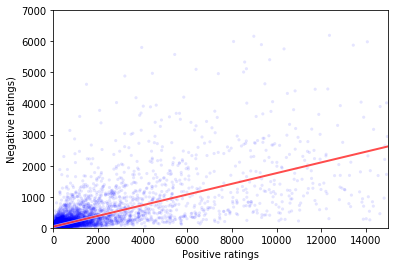

In [17]:
thinkplot.Scatter(pos, neg, color='blue', alpha=0.1, s=10)
thinkplot.Plot(fit_xs, fit_ys, color='white', linewidth=3)
thinkplot.Plot(fit_xs, fit_ys, color='red', linewidth=2)
thinkplot.Config(xlabel="Positive ratings",
                 ylabel='Negative ratings)',
                 axis=[0, 15000, 0, 7000],
                 legend=False)

# Residuals

In [30]:
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [31]:
data['residual'] = Residuals(pos, neg, inter, slope)

In [32]:
bins = np.arange(10, 48, 3)
indices = np.digitize(pos, bins)
groups = data.groupby(indices)

pos_means = [group.positive_ratings.mean() for _, group in groups][1:-1]
pos_means

[10.948755490483162,
 13.940869565217392,
 16.949473684210528,
 19.9514687100894,
 22.973645680819914,
 25.93526405451448,
 28.913533834586467,
 31.95131845841785,
 35.016666666666666,
 38.05434782608695,
 40.895161290322584,
 43.954703832752614]

In [33]:
cdfs = [thinkstats2.Cdf(group.residual) for _, group in groups][1:-1]

In [35]:
def PlotPercentiles(pos_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        neg_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(pos_means, neg_percentiles, label=label)

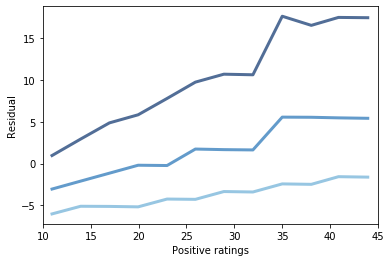

In [38]:
PlotPercentiles(pos_means, cdfs)

thinkplot.Config(xlabel="Positive ratings",
                 ylabel='Residual',
                 xlim=[10, 45])

I assume that it's safe to say that our data has linear relationship.

To plot residuals, we group positive and negative ratings and compute percentiles for each group. The plot above shows the 25, 50, 75th percentiles for each group.

# Sampling distribution


In [18]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

In [20]:
def SamplingDistributions(data, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(data)
        pos = sample.positive_ratings
        neg = sample.negative_ratings
        estimates = LeastSquares(pos, neg)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [24]:
inters, slopes = SamplingDistributions(data, iters=1001)
inters, slopes

((48.35685417084065,
  32.91716260619913,
  -110.86640431626157,
  45.076435213284356,
  52.168003328112974,
  -20.622016402563872,
  56.54374617918373,
  50.926722161663605,
  41.74560786740494,
  32.09757917168341,
  48.290039367726365,
  -23.20035871331706,
  38.063347241686984,
  39.129810131693205,
  33.82103377637554,
  38.30171553996351,
  -75.50411291861414,
  -124.58759460543988,
  -7.991484788566822,
  45.376062290592046,
  47.7047962631319,
  36.734538428893956,
  42.4568326420885,
  36.32107661368633,
  30.138876872636047,
  35.63562108782145,
  37.83911669445294,
  42.33353478484926,
  33.48859211211783,
  36.20317458004516,
  36.24861246655169,
  -29.340659363354746,
  54.30714128401945,
  53.091253895425965,
  30.896800475410032,
  47.743158885264876,
  54.18886746446648,
  -55.15494275484278,
  36.83509711049334,
  -68.04293888827459,
  -63.94777831247097,
  48.302483493773934,
  -91.18314529141767,
  44.51434254729821,
  35.34990834023637,
  44.072971655134296,
  49.45

In [25]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [26]:
Summarize(inters)

mean, SE, CI 26.130933439539216 39.22383226677389 (-55.54008607991415, 56.54374617918373)


In [27]:
Summarize(slopes)

mean, SE, CI 0.18618440998442368 0.054127780101651854 (0.1416032248179391, 0.3013048476468288)


The sampling distribution function of thinkstats shows how much the estimates would vary if we ran the experiment over and over. And we can also generate mean, Standard Error and Confindence Interval for this sampling distribution.

# Visualizing uncertainty

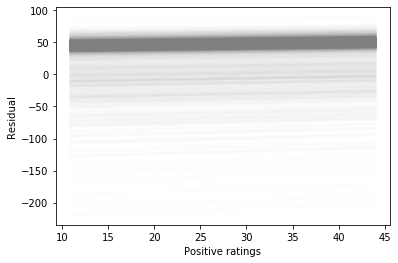

In [41]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(pos_means, inter, slope)
    thinkplot.Plot(fxs, fys, color='gray', alpha=0.01)
    
thinkplot.Config(xlabel="Positive ratings",
                 ylabel='Residual',
                 xlim=[10, 45])

In [42]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

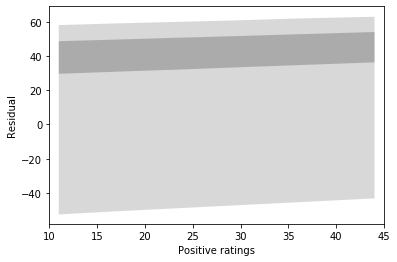

In [43]:
PlotConfidenceIntervals(pos_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(pos_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

thinkplot.Config(xlabel="Positive ratings",
                 ylabel='Residual',
                 xlim=[10, 45])

In this section we just simply plotted the confidence intervals gained from interception and slopes.

# Coefficient of determination

In [44]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

In [47]:
inter, slope = LeastSquares(pos, neg)
res = Residuals(pos, neg, inter, slope)
r2 = CoefDetermination(neg, res)
r2

0.5818703551060783

In [49]:
print('rho', thinkstats2.Corr(pos, neg))
print('R', np.sqrt(r2)) 

rho 0.7628042705085482
R 0.7628042705085482
